In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import requests
import warnings
import typing
import glob
import os
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

api_key = 'hFrBS7nzcaLTa8mplO1ejm44DI4EscDM'

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
warnings.simplefilter("ignore", category=UserWarning)

<h2>Load Data</h2>

In [2]:
jack_path = "/Users/jackdavis/Stocks/Research/Feb_research/jack"
csv_files = glob.glob(os.path.join(jack_path, "*.csv"))
dfs_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs_list, ignore_index=True)
df = df.sort_values(by=['date', 'ticker'])
pre_len = len(df)
df = df.dropna()    #drop nans. all but 7 are from last date (no close-open returns)
print(f'{pre_len - len(df)} observations dropped, {len(df)} remain')

2357 observations dropped, 148423 remain


In [20]:
df

,Unnamed: 0,ticker,timestamp_used,c,official_close_price,next_open_price,r,r_close_open,date,rhat_r,sr_r,rhat_r_close_open,sr_r_close_open,mean_revert_raw,mean_revert_specific,mr_prop_r_3,mr_prop_sr_3,mr_prop_r_5,mr_prop_sr_5,mr_prop_r_10,mr_prop_sr_10,mr_prop_r_21,mr_prop_sr_21,mr_prop_r_42,mr_prop_sr_42,weighted_mr_raw,weighted_mr_specific,mr_wprop_r_21,mr_wprop_sr_21
4811,159,A,2024-11-04 15:45:00-05:00,139.270,139.65,138.18,0.272851,-1.052632,2024-11-01,-0.130555,0.403406,-0.788061,-0.264570,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052632,0.000000,NaN,NaN
6459,1807,AA,2024-11-04 15:45:00-05:00,40.920,40.73,41.28,-0.464321,1.350356,2024-11-01,-0.115983,-0.348338,-0.008454,1.358810,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350356,1.358810,NaN,NaN
4955,303,AAL,2024-11-04 15:45:00-05:00,13.060,12.99,12.95,-0.535988,-0.307929,2024-11-01,-0.225375,-0.310613,-0.123713,-0.184216,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
6198,1546,AAOI,2024-11-04 15:45:00-05:00,16.490,16.40,16.80,-0.545785,2.439024,2024-11-01,-0.383876,-0.161909,1.481847,0.957177,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.439024,0.957177,NaN,NaN
4981,329,AAON,2024-11-04 15:45:00-05:00,112.470,112.46,112.57,-0.008891,0.097813,2024-11-01,-0.111891,0.103000,-0.392792,0.490604,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097813,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145703,1865,ZS,2025-02-06 15:45:00-05:00,203.745,204.23,207.02,0.238043,1.366107,2025-02-05,0.162612,0.075431,0.823492,0.542615,0,0,0.000000,0.333333,0.2,0.2,0.2,0.1,0.285714,0.238095,0.333333,0.309524,0.000000,0.000000,0.380904,0.078366
145332,1494,ZTS,2025-02-06 15:45:00-05:00,174.220,174.12,174.22,-0.057399,0.057432,2025-02-05,0.002739,-0.060138,0.262182,-0.204750,1,0,0.000000,0.666667,0.2,0.8,0.1,0.5,0.428571,0.428571,0.309524,0.309524,0.057432,0.000000,0.239672,0.308661
145531,1693,ZUO,2025-02-06 15:45:00-05:00,9.985,10.00,9.99,0.150225,-0.100000,2025-02-05,0.108666,0.041559,0.403107,-0.503107,0,1,0.000000,0.666667,0.0,0.6,0.1,0.3,0.190476,0.380952,0.190476,0.357143,0.000000,0.503107,0.019129,0.265790
144632,794,ZWS,2025-02-06 15:45:00-05:00,38.060,38.30,38.32,0.630583,0.052219,2025-02-05,0.219632,0.410951,0.066406,-0.014187,0,0,0.333333,0.666667,0.2,0.4,0.6,0.3,0.523810,0.238095,0.452381,0.309524,0.000000,0.000000,0.400693,0.068923


<h2>(1a)Compare raw return regressions to factor return regressions</h2>

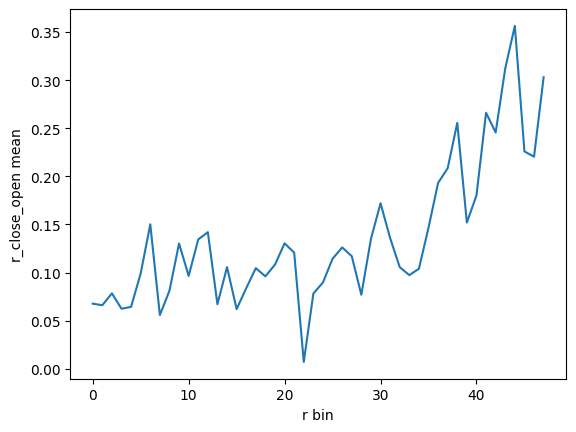

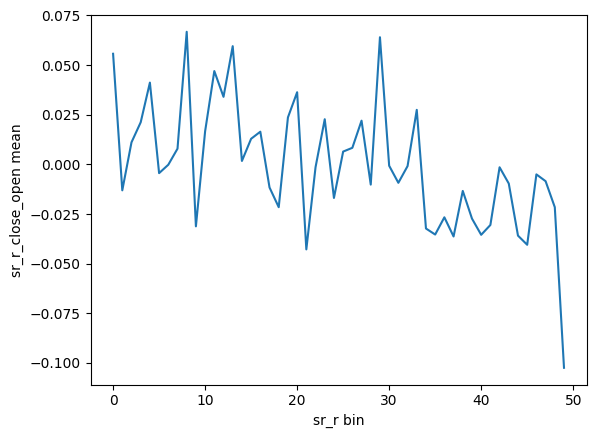

In [3]:
def qcut_mean_plot(x:str,y:str,df:pd.DataFrame):
    pltdf = df.copy()
    pltdf['x_bin'] = pd.qcut(df[x],q=50,duplicates='drop')
    gb = pltdf.groupby('x_bin')[y].mean().reset_index()
    plt.plot(gb.index,gb[y])
    plt.xlabel(f'{x} bin')
    plt.ylabel(f'{y} mean')
    plt.show()
qcut_mean_plot('r','r_close_open',df)
qcut_mean_plot('sr_r','sr_r_close_open',df)

In [4]:
#raw returns
X = sm.add_constant(df['r'])
Y = df['r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     32.07
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           1.49e-08
Time:                        22:02:05   Log-Likelihood:            -3.1580e+05
No. Observations:              148423   AIC:                         6.316e+05
Df Residuals:                  148421   BIC:                         6.316e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1284      0.005     24.463      0.0

<h3>Seeing the opposite of expected effect for raw returns - in my backtested universe the coefficient value is consistently negative</h3>

In [5]:
#specific returns
X = sm.add_constant(df['sr_r'])
Y = df['sr_r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sr_r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.96
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           0.000544
Time:                        22:02:07   Log-Likelihood:            -2.9617e+05
No. Observations:              148423   AIC:                         5.923e+05
Df Residuals:                  148421   BIC:                         5.924e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.094      0.9

<h3>This is more consistent with my results - negative coefficient</h3>
<h3>In both models, returns are statistically signicicant. Both models have poor r^2.</h3>

<h2>(1b)Missing tickers probably contain obersved raw returns relationship - tickers missing uploaded below</h2>
<h3>Need to find a way to determine what's not included in Barra and is in polygon</h3>

In [22]:
polygon_tickers = pd.read_csv('sample_tickers.csv')
polygon_tickers

,Unnamed: 0,date,ticker,type,name,primary_exchange,cik,composite_figi,share_class_figi,root,market_cap,shares_outstanding,market,lot_size,ticker_key,open,high,low,close,volume,vwap,timestamp,transactions,otc,dollar_volume,index,ticker_key_duplicate,type2
0,0,2024-05-20,A,CS,Agilent Technologies Inc.,XNYS,1090872.0,BBG000C2V3D6,BBG001SCTQY4,A,4.531807e+10,293055284.0,stocks,100.0,A_2024-05-20,153.970,154.9500,153.4650,154.6400,881963.0,154.5113,1.716178e+12,20312.0,NaN,1.362732e+08,52368432,0,CS
1,1,2024-05-20,AA,CS,Alcoa Corporation,XNYS,1675149.0,BBG00B3T3HD3,BBG00B3T3HF1,AA,7.636674e+09,179559688.0,stocks,100.0,AA_2024-05-20,41.170,42.8400,41.0200,42.5300,7201685.0,42.2549,1.716178e+12,57900.0,NaN,3.043065e+08,52368433,0,CS
2,2,2024-05-20,AAA,ETF,Alternative Access First Priority CLO Bond ETF,ARCX,1776878.0,BBG01B0JRCS6,BBG01B0JRCT5,AAA,NaN,NaN,stocks,100.0,AAA_2024-05-20,25.150,25.2300,25.0950,25.1577,3399.0,25.1560,1.716178e+12,38.0,NaN,8.550524e+04,52368434,0,ETF
3,3,2024-05-20,AAAU,ETF,Goldman Sachs Physical Gold ETF Shares,BATS,1708646.0,BBG00LPXX872,BBG00LPXX8Z1,AAAU,NaN,NaN,stocks,100.0,AAAU_2024-05-20,23.950,24.1250,23.8600,24.0150,2784906.0,24.0085,1.716178e+12,3882.0,NaN,6.686142e+07,52368435,0,ETF
4,4,2024-05-20,AACG,ADRC,ATA Creativity Global American Depositary Shares,XNAS,1420529.0,BBG000V2S3P6,BBG001T125S9,AACG,2.907450e+07,31950000.0,stocks,100.0,AACG_2024-05-20,0.910,0.9398,0.9001,0.9100,8612.0,0.9229,1.716178e+12,105.0,NaN,7.948015e+03,52368436,0,ADRC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012351,2012351,2025-02-06,ZWS,CS,Zurn Elkay Water Solutions Corporation,XNYS,1439288.0,BBG000H8R0N8,BBG001T36GB5,ZWS,6.522797e+09,170308023.0,stocks,100.0,ZWS_2025-02-06,38.160,38.3100,37.8100,38.3000,986636.0,38.1355,1.738818e+12,15238.0,NaN,3.762586e+07,54434032,0,CS
2012352,2012352,2025-02-06,ZYBT,CS,Zhengye Biotechnology Holding Limited Ordinary...,XNAS,1975641.0,NaN,NaN,ZYBT,1.971555e+08,47166376.0,stocks,100.0,ZYBT_2025-02-06,4.200,4.3400,4.0041,4.1800,19164.0,4.1826,1.738818e+12,1245.0,NaN,8.015535e+04,54434033,0,CS
2012353,2012353,2025-02-06,ZYME,CS,Zymeworks Inc.,XNAS,1937653.0,BBG019XSYC89,BBG019XSYC98,ZYME,1.026964e+09,68877526.0,stocks,100.0,ZYME_2025-02-06,14.990,15.1400,14.6853,14.9100,220034.0,14.9316,1.738818e+12,3692.0,NaN,3.285460e+06,54434034,0,CS
2012354,2012354,2025-02-06,ZYXI,CS,ZYNEX INC,XNAS,846475.0,BBG000BJBXZ2,BBG001S7T7V0,ZYXI,2.522167e+08,31845545.0,stocks,100.0,ZYXI_2025-02-06,7.960,8.0900,7.9110,7.9200,51884.0,7.9873,1.738818e+12,893.0,NaN,4.144131e+05,54434035,0,CS


<h2>(2) Bayseian Coin Flipping</h2>
<h3>(2a)Start by looking at the proportion of previous close_open (raw and specific) returns that mean reverted on different lookbacks</h3>


In [6]:
df['mean_revert_raw'] = np.where((df['r'] * df['r_close_open'] < 0) & (abs(df['r']) < abs(df['r_close_open'])), 1, 0)       #create mean reversion indicator for raw returns
df['mean_revert_specific'] = np.where((df['sr_r'] * df['sr_r_close_open'] < 0) & (abs(df['sr_r']) < abs(df['sr_r_close_open'])), 1, 0)

def proportion_mean_reversion(ticker:str,lookback:int):
    '''Get proportion of previous instances that mean reverted'''
    tickerdf = df[df['ticker'] == ticker].copy()
    tickerdf[f'mr_prop_r_{lookback}'] = tickerdf['mean_revert_raw'].shift(1).rolling(lookback).mean()
    tickerdf[f'mr_prop_sr_{lookback}'] = tickerdf['mean_revert_specific'].shift(1).rolling(lookback).mean()
    return tickerdf[[f'mr_prop_r_{lookback}',f'mr_prop_sr_{lookback}']]

for lookback in [3,5,10,21,42]:
    lookback_ticker_dfs = []
    for ticker in df['ticker'].unique():
        lookback_ticker_dfs.append(proportion_mean_reversion(ticker,lookback))
    lookback_df = pd.concat(lookback_ticker_dfs,axis=0)
    df = pd.merge(df,lookback_df,how='left',left_index=True,right_index=True)
df

,Unnamed: 0,ticker,timestamp_used,c,official_close_price,next_open_price,r,r_close_open,date,rhat_r,sr_r,rhat_r_close_open,sr_r_close_open,mean_revert_raw,mean_revert_specific,mr_prop_r_3,mr_prop_sr_3,mr_prop_r_5,mr_prop_sr_5,mr_prop_r_10,mr_prop_sr_10,mr_prop_r_21,mr_prop_sr_21,mr_prop_r_42,mr_prop_sr_42
4811,159,A,2024-11-04 15:45:00-05:00,139.270,139.65,138.18,0.272851,-1.052632,2024-11-01,-0.130555,0.403406,-0.788061,-0.264570,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6459,1807,AA,2024-11-04 15:45:00-05:00,40.920,40.73,41.28,-0.464321,1.350356,2024-11-01,-0.115983,-0.348338,-0.008454,1.358810,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4955,303,AAL,2024-11-04 15:45:00-05:00,13.060,12.99,12.95,-0.535988,-0.307929,2024-11-01,-0.225375,-0.310613,-0.123713,-0.184216,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6198,1546,AAOI,2024-11-04 15:45:00-05:00,16.490,16.40,16.80,-0.545785,2.439024,2024-11-01,-0.383876,-0.161909,1.481847,0.957177,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4981,329,AAON,2024-11-04 15:45:00-05:00,112.470,112.46,112.57,-0.008891,0.097813,2024-11-01,-0.111891,0.103000,-0.392792,0.490604,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145703,1865,ZS,2025-02-06 15:45:00-05:00,203.745,204.23,207.02,0.238043,1.366107,2025-02-05,0.162612,0.075431,0.823492,0.542615,0,0,0.000000,0.333333,0.2,0.2,0.2,0.1,0.285714,0.238095,0.333333,0.309524
145332,1494,ZTS,2025-02-06 15:45:00-05:00,174.220,174.12,174.22,-0.057399,0.057432,2025-02-05,0.002739,-0.060138,0.262182,-0.204750,1,0,0.000000,0.666667,0.2,0.8,0.1,0.5,0.428571,0.428571,0.309524,0.309524
145531,1693,ZUO,2025-02-06 15:45:00-05:00,9.985,10.00,9.99,0.150225,-0.100000,2025-02-05,0.108666,0.041559,0.403107,-0.503107,0,1,0.000000,0.666667,0.0,0.6,0.1,0.3,0.190476,0.380952,0.190476,0.357143
144632,794,ZWS,2025-02-06 15:45:00-05:00,38.060,38.30,38.32,0.630583,0.052219,2025-02-05,0.219632,0.410951,0.066406,-0.014187,0,0,0.333333,0.666667,0.2,0.4,0.6,0.3,0.523810,0.238095,0.452381,0.309524


<h3>Use previous mean reversion proportion to predict binary mean reversion</h3>

In [7]:
for x,y in zip(['mr_prop_r_3','mr_prop_r_5','mr_prop_r_10','mr_prop_r_21','mr_prop_r_42','mr_prop_sr_3','mr_prop_sr_5','mr_prop_sr_10','mr_prop_sr_21','mr_prop_sr_42'],5 * ['mean_revert_raw'] + 5 * ['mean_revert_specific']):
    cleandf = df[[x,y]].dropna().copy()
    X = sm.add_constant(cleandf[x])
    Y = cleandf[y]
    model = sm.Logit(Y,X).fit(disp=False)
    y_true = model.model.endog
    y_pred_probs = model.predict()
    auc_roc = roc_auc_score(y_true, y_pred_probs)
    b1 = model.params[1]
    odds_ratio = np.exp(b1)
    print(f'{x}. b0:{round(model.params[0],4)} b1:{round(b1,3)}, auc_roc: {auc_roc} t-stat: {round(model.tvalues[1],2)}, # obs: {model.nobs}')

mr_prop_r_3. b0:-0.7466 b1:0.04, auc_roc: 0.5033936738273257 t-stat: 1.91, # obs: 141304
mr_prop_r_5. b0:-0.77 b1:0.096, auc_roc: 0.5054937659492216 t-stat: 3.5, # obs: 136560
mr_prop_r_10. b0:-0.8291 b1:0.272, auc_roc: 0.5119700308190707 t-stat: 6.83, # obs: 124706
mr_prop_r_21. b0:-0.8389 b1:0.489, auc_roc: 0.5148368323441411 t-stat: 7.8, # obs: 98768
mr_prop_r_42. b0:-0.7686 b1:0.523, auc_roc: 0.5121722647963395 t-stat: 4.28, # obs: 50046
mr_prop_sr_3. b0:-0.7433 b1:0.101, auc_roc: 0.5073833192546314 t-stat: 4.92, # obs: 141304
mr_prop_sr_5. b0:-0.7655 b1:0.164, auc_roc: 0.5094195270208661 t-stat: 6.11, # obs: 136560
mr_prop_sr_10. b0:-0.8152 b1:0.331, auc_roc: 0.514226001090388 t-stat: 8.46, # obs: 124706
mr_prop_sr_21. b0:-0.902 b1:0.585, auc_roc: 0.518051521458014 t-stat: 9.44, # obs: 98768
mr_prop_sr_42. b0:-1.0071 b1:1.07, auc_roc: 0.525379670063793 t-stat: 9.19, # obs: 50046


<h3>Longer lookback periods are more statistically significant and have higher odds ratios. Lookback of ~1 month seems to be ideal</h3>
<h3>Specific returns are more significant than raw returns. Auc_roc is low.</h3>
<h3>(2b) Use mean reversion proportion with 21 day lookback as feature in original OLS returns regressions</h3>

In [8]:
#raw returns
cleandf = df[['r','mr_prop_r_21','r_close_open']].dropna()
cleandf['signed_proportion'] = np.where(cleandf['r'] == 0,0,(cleandf['r']/abs(cleandf['r'])) * cleandf['mr_prop_r_21'])
X = sm.add_constant(cleandf[['r','signed_proportion']])
Y = cleandf['r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.699
Date:                Wed, 19 Feb 2025   Prob (F-statistic):              0.183
Time:                        22:02:59   Log-Likelihood:            -2.0738e+05
No. Observations:               98768   AIC:                         4.148e+05
Df Residuals:                   98765   BIC:                         4.148e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0483      0.00

In [9]:
#specific returns
cleandf = df[['sr_r','mr_prop_sr_21','sr_r_close_open']].dropna()
cleandf['signed_proportion'] = np.where(cleandf['sr_r'] == 0,0,(cleandf['sr_r']/abs(cleandf['sr_r'])) * cleandf['mr_prop_sr_21'])
X = sm.add_constant(cleandf[['sr_r','signed_proportion']])
Y = cleandf['sr_r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sr_r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.042
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           0.000875
Time:                        22:02:59   Log-Likelihood:            -1.9541e+05
No. Observations:               98768   AIC:                         3.908e+05
Df Residuals:                   98765   BIC:                         3.908e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0051      0.00

<h3>Both coefficients are statistically significant - as expected. However, neither are statistically significant</h3>
<h3>(2c) Use signed logit Prob(mean reversion) as feature in OLS regressions</h3>

In [10]:
#raw returns
cleandf = df[['r','mr_prop_r_21','r_close_open']].dropna()
cleandf['mr_prob'] = 1 / (1 + np.exp(-(-0.8389 + 0.489 * df['mr_prop_r_21'])))
cleandf['signed_probability'] = np.where(cleandf['r'] == 0,0,(cleandf['r']/abs(cleandf['r'])) * cleandf['mr_prob'])
X = sm.add_constant(cleandf[['r','signed_probability']])
Y = cleandf['r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.383
Date:                Wed, 19 Feb 2025   Prob (F-statistic):              0.251
Time:                        22:02:59   Log-Likelihood:            -2.0738e+05
No. Observations:               98768   AIC:                         4.148e+05
Df Residuals:                   98765   BIC:                         4.148e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0482      0

In [11]:
#specific
cleandf = df[['sr_r','mr_prop_sr_21','sr_r_close_open']].dropna()
cleandf['mr_prob'] = 1 / (1 + np.exp(-(-0.902 + 0.585 * df['mr_prop_sr_21'])))
cleandf['signed_probability'] = np.where(cleandf['sr_r'] == 0,0,(cleandf['sr_r']/abs(cleandf['sr_r'])) * cleandf['mr_prob'])
X = sm.add_constant(cleandf[['sr_r','signed_probability']])
Y = cleandf['sr_r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sr_r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.623
Date:                Wed, 19 Feb 2025   Prob (F-statistic):            0.00362
Time:                        22:02:59   Log-Likelihood:            -1.9541e+05
No. Observations:               98768   AIC:                         3.908e+05
Df Residuals:                   98765   BIC:                         3.908e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0051      0

<h3>Signed probability feature is also largely insignificant</h3>
<h3>(2d)Try using mean reversion probability as weights in WLS regression</h3>

In [12]:
#raw returns
cleandf = df[['r','mr_prop_r_21','r_close_open']].dropna()
cleandf['mr_prob'] = 1 / (1 + np.exp(-(-0.8389 + 0.489 * df['mr_prop_r_21'])))
X = sm.add_constant(cleandf['r'])
Y = cleandf['r_close_open']
weights = cleandf['mr_prob']
model = sm.WLS(Y, X, weights=weights).fit(cov_type='HC3')
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:           r_close_open   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.649
Date:                Wed, 19 Feb 2025   Prob (F-statistic):              0.104
Time:                        22:02:59   Log-Likelihood:            -2.0672e+05
No. Observations:               98768   AIC:                         4.134e+05
Df Residuals:                   98766   BIC:                         4.135e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0486      0.006      7.882      0.0

In [13]:
#specific
cleandf = df[['sr_r','mr_prop_sr_21','sr_r_close_open']].dropna()
cleandf['mr_prob'] = 1 / (1 + np.exp(-(-0.902 + 0.585 * df['mr_prop_sr_21'])))
X = sm.add_constant(cleandf['sr_r'])
Y = cleandf['sr_r_close_open']
weights = cleandf['mr_prob']
model = sm.WLS(Y, X, weights=weights).fit(cov_type='HC3')
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:        sr_r_close_open   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.647
Date:                Wed, 19 Feb 2025   Prob (F-statistic):            0.00328
Time:                        22:02:59   Log-Likelihood:            -1.9572e+05
No. Observations:               98768   AIC:                         3.914e+05
Df Residuals:                   98766   BIC:                         3.915e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.006      0.935      0.3

<h3>Using as mean reversion probability as weights doesn't change much<h3>
<h3>(2e) Weight mean reversion proportion by absolute values of close-open returns</h3>

In [14]:
df['weighted_mr_raw'] = df['mean_revert_raw'] * abs(df['r_close_open'])
df['weighted_mr_specific'] = df['mean_revert_specific'] * abs(df['sr_r_close_open'])

def weighted_proportion_mean_reversion(ticker:str,lookback:int):
    '''Get proportion of previous instances that mean reverted with weights'''
    tickerdf = df[df['ticker'] == ticker].copy()
    tickerdf[f'mr_wprop_r_{lookback}'] = tickerdf['weighted_mr_raw'].shift(1).rolling(lookback).mean()
    tickerdf[f'mr_wprop_sr_{lookback}'] = tickerdf['weighted_mr_specific'].shift(1).rolling(lookback).mean()
    return tickerdf[[f'mr_wprop_r_{lookback}',f'mr_wprop_sr_{lookback}']]

lookback_ticker_dfs = []
for ticker in df['ticker'].unique():
    lookback_ticker_dfs.append(weighted_proportion_mean_reversion(ticker,21))
lookback_df = pd.concat(lookback_ticker_dfs,axis=0)
df = pd.merge(df,lookback_df,how='left',left_index=True,right_index=True)
df

,Unnamed: 0,ticker,timestamp_used,c,official_close_price,next_open_price,r,r_close_open,date,rhat_r,sr_r,rhat_r_close_open,sr_r_close_open,mean_revert_raw,mean_revert_specific,mr_prop_r_3,mr_prop_sr_3,mr_prop_r_5,mr_prop_sr_5,mr_prop_r_10,mr_prop_sr_10,mr_prop_r_21,mr_prop_sr_21,mr_prop_r_42,mr_prop_sr_42,weighted_mr_raw,weighted_mr_specific,mr_wprop_r_21,mr_wprop_sr_21
4811,159,A,2024-11-04 15:45:00-05:00,139.270,139.65,138.18,0.272851,-1.052632,2024-11-01,-0.130555,0.403406,-0.788061,-0.264570,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052632,0.000000,NaN,NaN
6459,1807,AA,2024-11-04 15:45:00-05:00,40.920,40.73,41.28,-0.464321,1.350356,2024-11-01,-0.115983,-0.348338,-0.008454,1.358810,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350356,1.358810,NaN,NaN
4955,303,AAL,2024-11-04 15:45:00-05:00,13.060,12.99,12.95,-0.535988,-0.307929,2024-11-01,-0.225375,-0.310613,-0.123713,-0.184216,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
6198,1546,AAOI,2024-11-04 15:45:00-05:00,16.490,16.40,16.80,-0.545785,2.439024,2024-11-01,-0.383876,-0.161909,1.481847,0.957177,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.439024,0.957177,NaN,NaN
4981,329,AAON,2024-11-04 15:45:00-05:00,112.470,112.46,112.57,-0.008891,0.097813,2024-11-01,-0.111891,0.103000,-0.392792,0.490604,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097813,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145703,1865,ZS,2025-02-06 15:45:00-05:00,203.745,204.23,207.02,0.238043,1.366107,2025-02-05,0.162612,0.075431,0.823492,0.542615,0,0,0.000000,0.333333,0.2,0.2,0.2,0.1,0.285714,0.238095,0.333333,0.309524,0.000000,0.000000,0.380904,0.078366
145332,1494,ZTS,2025-02-06 15:45:00-05:00,174.220,174.12,174.22,-0.057399,0.057432,2025-02-05,0.002739,-0.060138,0.262182,-0.204750,1,0,0.000000,0.666667,0.2,0.8,0.1,0.5,0.428571,0.428571,0.309524,0.309524,0.057432,0.000000,0.239672,0.308661
145531,1693,ZUO,2025-02-06 15:45:00-05:00,9.985,10.00,9.99,0.150225,-0.100000,2025-02-05,0.108666,0.041559,0.403107,-0.503107,0,1,0.000000,0.666667,0.0,0.6,0.1,0.3,0.190476,0.380952,0.190476,0.357143,0.000000,0.503107,0.019129,0.265790
144632,794,ZWS,2025-02-06 15:45:00-05:00,38.060,38.30,38.32,0.630583,0.052219,2025-02-05,0.219632,0.410951,0.066406,-0.014187,0,0,0.333333,0.666667,0.2,0.4,0.6,0.3,0.523810,0.238095,0.452381,0.309524,0.000000,0.000000,0.400693,0.068923


<h3>Use weighted proportions as regression features</h3>

In [18]:
#raw returns
cleandf = df[['r','mr_wprop_r_21','r_close_open']].dropna()
cleandf['signed_proportion_weighted'] = np.where(cleandf['r'] == 0,0,(cleandf['r']/abs(cleandf['r'])) * cleandf['mr_wprop_r_21'])
X = sm.add_constant(cleandf[['r','signed_proportion_weighted']])
Y = cleandf['r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.358
Date:                Wed, 19 Feb 2025   Prob (F-statistic):              0.257
Time:                        22:07:10   Log-Likelihood:            -2.0738e+05
No. Observations:               98768   AIC:                         4.148e+05
Df Residuals:                   98765   BIC:                         4.148e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [19]:
#specific returns
cleandf = df[['sr_r','mr_wprop_sr_21','sr_r_close_open']].dropna()
cleandf['signed_proportion_weighted'] = np.where(cleandf['sr_r'] == 0,0,(cleandf['sr_r']/abs(cleandf['sr_r'])) * cleandf['mr_wprop_sr_21'])
X = sm.add_constant(cleandf[['sr_r','signed_proportion_weighted']])
Y = cleandf['sr_r_close_open']
model = sm.OLS(Y,X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sr_r_close_open   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.076
Date:                Wed, 19 Feb 2025   Prob (F-statistic):            0.00625
Time:                        22:07:14   Log-Likelihood:            -1.9540e+05
No. Observations:               98768   AIC:                         3.908e+05
Df Residuals:                   98765   BIC:                         3.908e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<h3>Weighted signed mean reversion proportion is statistically significant - only model with this feature</h3>
<h3>For meeting - wanted to talk about ways to refine idea of weighting probabilities by move</h3>
<h3>Significance could just be coming from rolling average of specific close-open returns </h3>